# Python Application Chapter 

## Managing the imports and implementation of the data set

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from tqdm import tnrange,tqdm_notebook
from sklearn import linear_model
import itertools
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.metrics import mean_squared_error as m
import random

df = pd.read_csv("NBA_salaries_and_stats.csv", sep=",")

## Using only variables that are not dependent on each other

In [4]:
df=df[['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']]

## Implementing created methods

In [3]:
#this method adds a intercept to a given dataframe    
def intercept_add(df):
    df['Intercept']=1.0
    return df

#this method performs linear regression of a given X and Y 
#then the RSS and R-squared are computed with the sklearn module
def lrg(X,Y):
    model=linear_model.LinearRegression()#fit_intercept=True
    model.fit(X,Y)
    RSS= mean_squared_error(Y,model.predict(X))*len(Y)
    R_squared= model.score(X,Y)
    return RSS,R_squared

## Subset selection processes
* **best subset**
* **forward stepwise selection**
* **backward stepwise elimination**
* **information criterion selection**

In [4]:
def best_subset(df,output='pred'):
    '''This function calculates all subsets of a given DataFrame-object'''
    X,y=df[df.columns.difference([output])],df[output]#defining the target variable and the regressormatrix
    #initializing empty lists to save the RSS,R-squared,subset variables and the number of variables
    RSS_list,R_squared_list,variable_list,number_variables=[],[],[],[]
    #running through all possible counts of subsets
    for k in range(1,len(X.columns)+1):
        #looping over all possible subsets with size k
        for combo in itertools.combinations(X.columns,k):
            model=lrg(X[list(combo)],y)#returns the RSS- and the R-squared value of the linear regression
            #appending the results of the current subset
            RSS_list.append(model[0])
            R_squared_list.append(model[1])
            variable_list.append(list(combo))
            number_variables.append(len(combo))
    #saving the results in a pandas DataFrame-object
    df_best_subset = pd.concat([pd.DataFrame({'variables':variable_list}),pd.DataFrame({'number_of_variables':number_variables}),
                        pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
    #saving the best RSS and the best R-squared results for each different subset size in new columns
    df_best_subset['min_RSS']=df_best_subset.groupby('number_of_variables')['RSS'].transform(min)
    df_best_subset['max_R_squared']=df_best_subset.groupby('number_of_variables')['R_squared'].transform(max)

    return df_best_subset

In [5]:
def forward_stepwise(df,output='pred'):
    '''This function calculates the forward stepwise subset selections of a given DataFrame-object'''
    y_train,df=df[output],df[df.columns.difference([output])]#defining the output and regressors
    k=df.shape[1]#saving the count of variables available in the Regressormatrix
    #2 lists for the not included and included regressors
    remaining_features,selected_features = list(df.columns.difference(['Intercept']).values),[]
    #empty lists and an empty dictionary to save results in each iteration of the following for loop 
    RSS_list, R_squared_list,features_dict = [np.inf], [np.inf],dict() 
    #the outer for loop iterates over the number of available regressors
    for i in range(1,k):
        best_RSS = np.inf#defining an upper limitation for the possible RSS value
        #the inner for loop is iterating over each combination, of one regressor, out of the remaining features
        for combo in itertools.combinations(remaining_features,1):
            #calculating the linear regression model for the combination plus the already selected features 
            model = lrg(df[list(combo) + selected_features],y_train)
            #checking whether the current selection model has a lower RSS, than other selections
            if (model[0] < best_RSS):
                #overwriting the 'best' values
                best_RSS,best_R_squared,best_feature = model[0],model[1],combo[0]
        #updating the remaining and included regressor lists, after each combination has been looked at 
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        #appending the current selection to the lists
        RSS_list.append(best_RSS)
        R_squared_list.append(best_R_squared)
        features_dict[i] = selected_features.copy()
    #creating the output DataFrame-Object   
    df1 = pd.concat([pd.DataFrame({'variables':features_dict}),
                     pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
    df1['number of variables'] = df1.index
    return df1

In [6]:
def backwards_elimination(df,output='pred'):
    '''This function calculates the backward elimination subset selections of a given DataFrame-object'''
    y,df=df[output],df[df.columns.difference([output])]#defining the output and regressors
    k=df.shape[1]#saving the count of variables available in the Regressormatrix
    variables = list(df.columns.difference(['Intercept']).values)
    RSS_list, R_squared_list,variables_list,eliminated = [0], [0],dict(),['None']
    #calculating the output values for the full model
    for i in range(1,k):#first for loop to iterate over the amount of possible subset sizes
        temp_RSS_list,c,best_RSS=[],[],np.inf
        #Checking all possible subsets and saving the results
        for combo in itertools.combinations(variables,1):
            if len(variables)>1:#only remove when there are at least 2 variables left
                variables.remove(list(combo)[0])
                model = lrg(df[variables],y)  
                temp_RSS_list.append(model[0])
                if (model[0] < best_RSS):
                #overwriting the 'best' values
                    best_RSS,best_R_squared,worst_feature = model[0],model[1],combo[0]
                variables=variables.copy()+list(combo)
        #adding the results of the iteration
        eliminated.append(worst_feature)
        RSS_list.append(best_RSS)
        R_squared_list.append(best_R_squared)
        variables.remove(worst_feature)
        variables_list[i] = variables.copy()  
    #saving the reults in a DataFrame
    df_be = pd.concat([pd.DataFrame({'Variables':variables_list}),
                       pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list}),
                       pd.DataFrame({'Eliminated':eliminated})], axis=1, join='inner')
    df_be['Number_of_variables']=[len(i) for i in df_be['Variables']]
    return df_be

In [7]:
from scipy import stats
from sklearn.metrics import mean_squared_error as m
def ic(df_subset,df1,df_test,output='pred'):
    '''This method compares the subset-results with Information criteria and direct estimation of the test mse'''
    Xtr,ytr=df1[df1.columns.difference([output])],df1[output]
    Xtst,ytst=df_test[df_test.columns.difference([output])],df_test[output]#the test split from our data
    aicl,bicl,ricl,variables,mse_list=[],[],[],[],[]#lists to save the temporary results of the Information criteria
    for i in df_subset:
        x,y=Xtr[i],ytr#defining x as the selected subsets of the data 
        model = sm.OLS(y, x).fit()#fitting the model
        aicl.append(model.aic)#saving the Information criteria and the related variables
        bicl.append(model.bic)
        ricl.append(model.rsquared_adj)
        pred_y=model.predict(Xtst[i])#predicting the target variable
        mse= m(ytst,pred_y)#calculating the test mse of our predictions and the actual values 
        mse_list.append(mse)
        variables.append(i)
    #saving our results in a DataFrame
    df=pd.concat([pd.DataFrame({'aic':aicl}),pd.DataFrame({'bic':bicl}),pd.DataFrame({'r_squaredadj':ricl})
                  ,pd.DataFrame({'variables':variables}),pd.DataFrame({'mse':mse_list})], axis=1, join='inner')
    df['nf']=[len(i) for i in df['variables']]#saving the number of variables in a new column
    #output DataFrame for the optimal selection of each Information criterion (minimum and maximum)
    df=df.dropna()
    df_selection=pd.concat([df[df['aic']==min(df['aic'])],df[df['bic']==min(df['bic'])],
               df[df['r_squaredadj']==max(df['r_squaredadj'])],df[df['mse']==min(df['mse'])]],join='inner')
    #display(df_selection,df[df['r_squaredadj']==max(df['r_squaredadj'])])
    df_selection['']=['MIN AIC','MIN BIC','MAX ADJ. R-sq.','MIN MSE TEST']
    df_selection=df_selection.set_index('')
    #an output dictionary for the one standard error rule selection
    df_selection_one_se=dict()
    df_selection_one_se['One SE AIC']=min(df[df['aic']-stats.sem(df.aic)<=min(df['aic'])]['nf'])
    df_selection_one_se['One SE BIC']=min(df[df['bic']-stats.sem(df.bic)<=min(df['bic'])]['nf'])
    df_selection_one_se['One SE adj R sq']=min(
        df[df['r_squaredadj']+stats.sem(df.r_squaredadj)>=max(df['r_squaredadj'])]['nf'])
    df_selection_one_se['One SE MSE']=min(df[df['mse']-stats.sem(df.mse)<=min(df['mse'])]['nf'])
    return df,df_selection,df_selection_one_se

## Working with the subset methods

In [8]:
#creating a training and testing dataframe
df_train= df.sample(frac=0.7,random_state=1)
df_test=df.drop(df_train.index)
#comparing the three methods with the first 14 variables of the dataset
df_train_auswahl=df_train.iloc[:,:14]
df_train_auswahl['salary']=df_train['salary']

## **`best subset`**

In [9]:
#calculating the best subset selection process and saving it as df_bs
df_bs=best_subset(df_train_auswahl,output='salary')
#filter df_bs after the subsets with the minimal RSS and displaying the results in the end
df_bs_min_rss=df_bs[df_bs['min_RSS']==df_bs['RSS']][['number_of_variables','RSS','R_squared','variables']].reset_index()
df_bs_min_rss=df_bs_min_rss.drop(['index'], axis=1)
display(df_bs_min_rss)#this diplays the Figure 4.2.2

,number_of_variables,RSS,R_squared,variables
0,1,1.089929e+16,0.497275,[FP]
1,2,8.291898e+15,0.617540,"[AGE, FP]"
2,3,7.826176e+15,0.639021,"[AGE, FG%, FP]"
3,4,7.631272e+15,0.648011,"[3P%, AGE, FG%, FP]"
4,5,7.487532e+15,0.654641,"[+/-, 3P%, AGE, FG%, FP]"
5,6,7.383353e+15,0.659446,"[+/-, 3P%, AGE, FG%, FP, PTS]"
6,7,7.284740e+15,0.663995,"[+/-, 3P%, AGE, DD2, FG%, FP, PTS]"
7,8,7.247789e+15,0.665699,"[+/-, 3P%, AGE, DD2, FG%, FP, GP, PTS]"
8,9,7.225291e+15,0.666737,"[+/-, 3P%, AGE, DD2, FG%, FP, GP, PF, PTS]"
9,10,7.217586e+15,0.667092,"[+/-, 3P%, AGE, DD2, FG%, FP, FT%, GP, PF, PTS]"


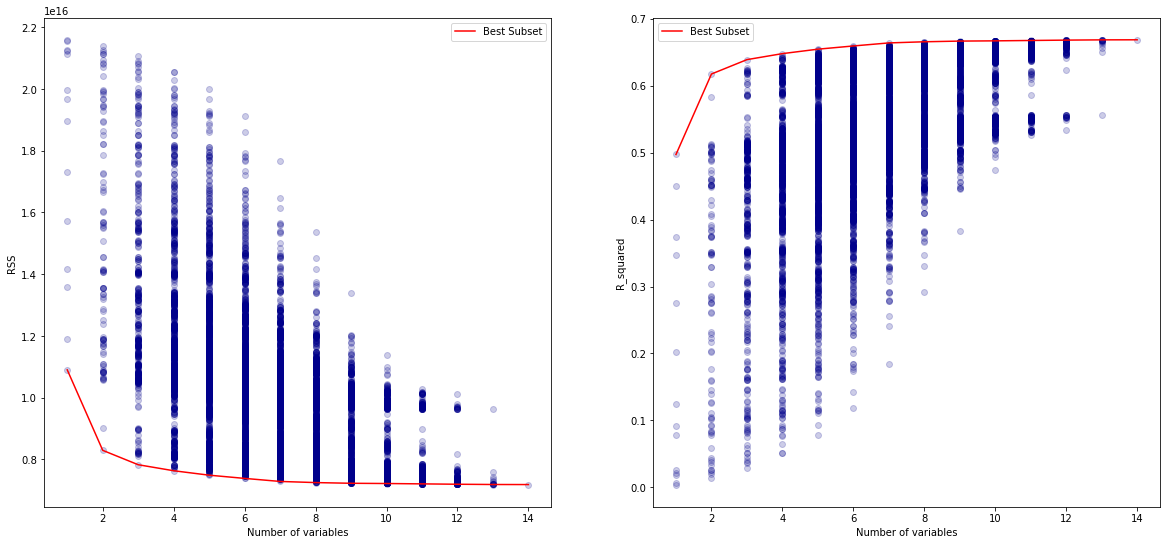

In [10]:
#the following plots show all subsets in blue and the best subset choice in red 
#with their corresponding RSS/R-squared values
fig=plt.figure(figsize=(20,9))
ax=fig.add_subplot(1,2,1)
ax.scatter(df_bs.number_of_variables,df_bs.RSS,alpha=0.2,color='darkblue')
ax.set_xlabel('Number of variables')
ax.set_ylabel('RSS')
ax.plot(df_bs.number_of_variables,df_bs.min_RSS,color='r',label='Best Subset')
ax.legend()
ax=fig.add_subplot(1,2,2)
ax.scatter(df_bs.number_of_variables,df_bs.R_squared,alpha=0.2,color='darkblue')
ax.set_xlabel('Number of variables')
ax.set_ylabel('R_squared')
ax.plot(df_bs.number_of_variables,df_bs.max_R_squared,color='r',label='Best Subset')
ax.legend()
plt.show()

In [11]:
#showing the optimal subset for each information criterion
df1,df2,df3=ic(df_bs_min_rss['variables'],df_train_auswahl,df_test,output='salary')
print(display(df2))

,aic,bic,r_squaredadj,variables,mse,nf
,,,,,,
MIN AIC,6930.911736,6957.417383,0.819272,"[+/-, 3P%, AGE, DD2, FG%, FP, GP, PTS]",3.457007e+13,8
MIN BIC,6930.911736,6957.417383,0.819272,"[+/-, 3P%, AGE, DD2, FG%, FP, GP, PTS]",3.457007e+13,8
MAX ADJ. R-sq.,6932.041588,6965.173647,0.819963,"[+/-, 3P%, AGE, DD2, FG%, FP, FT%, GP, PF, PTS]",3.356248e+13,10
MIN MSE TEST,6935.228785,6974.987257,0.818804,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, FP, FT%, G...",3.286815e+13,12


None


## **`forward stepwise selection`**

In [12]:
df_fss=forward_stepwise(df_train_auswahl,output='salary')
display(df_fss)#this diplays the Figure 4.3.2

,variables,RSS,R_squared,number of variables
1,[FP],1.089929e+16,0.497275,1
2,"[FP, AGE]",8.291898e+15,0.617540,2
3,"[FP, AGE, FG%]",7.826176e+15,0.639021,3
4,"[FP, AGE, FG%, 3P%]",7.631272e+15,0.648011,4
5,"[FP, AGE, FG%, 3P%, +/-]",7.487532e+15,0.654641,5
6,"[FP, AGE, FG%, 3P%, +/-, PTS]",7.383353e+15,0.659446,6
7,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2]",7.284740e+15,0.663995,7
8,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP]",7.247789e+15,0.665699,8
9,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP, PF]",7.225291e+15,0.666737,9
10,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP, PF, FT%]",7.217586e+15,0.667092,10


In [13]:
#calculating and showing the optimal subset for each information criterion
df1,df2,df3=ic(df_fss['variables'],df_train,df_test,output='salary')
display(df2)

,aic,bic,r_squaredadj,variables,mse,nf
,,,,,,
MIN AIC,6930.911736,6957.417383,0.819272,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP]",3.457007e+13,8
MIN BIC,6930.911736,6957.417383,0.819272,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP]",3.457007e+13,8
MAX ADJ. R-sq.,6932.041588,6965.173647,0.819963,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP, PF, FT%]",3.356248e+13,10
MIN MSE TEST,6935.228785,6974.987257,0.818804,"[FP, AGE, FG%, 3P%, +/-, PTS, DD2, GP, PF, FT%...",3.286815e+13,12


## **`backward stepwise elimination`**

In [14]:
df_be=backwards_elimination(df_train_auswahl,output='salary')
display(df_be)#this display is shown as Fig. 4.4.2

,Variables,RSS,R_squared,Eliminated,Number_of_variables
1,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, FT%, GP, M...",7.185583e+15,0.668568,FP,13
2,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, MIN, P...",7.194414e+15,0.668161,FT%,12
3,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PF, PT...",7.207181e+15,0.667572,MIN,11
4,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PTS, REB]",7.222090e+15,0.666884,PF,10
5,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PTS]",7.253175e+15,0.665450,REB,9
6,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, PTS]",7.280694e+15,0.664181,GP,8
7,"[+/-, 3P%, AGE, AST, DD2, FG%, PTS]",7.427065e+15,0.657430,BLK,7
8,"[+/-, 3P%, AGE, DD2, FG%, PTS]",7.550906e+15,0.651718,AST,6
9,"[3P%, AGE, DD2, FG%, PTS]",7.771981e+15,0.641521,+/-,5
10,"[3P%, AGE, DD2, PTS]",8.141361e+15,0.624483,FG%,4


In [15]:
#calculating and showing the optimal subset for each information criterion
df1,df2,df3=ic(df_be['Variables'],df_train,df_test,output='salary')
display(df2)

,aic,bic,r_squaredadj,variables,mse,nf
,,,,,,
MIN AIC,6932.757739,6962.576593,0.818478,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PTS]",3.348882e+13,9
MIN BIC,6939.480169,6959.359404,0.809681,"[+/-, 3P%, AGE, DD2, FG%, PTS]",3.630277e+13,6
MAX ADJ. R-sq.,6932.757739,6962.576593,0.818478,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PTS]",3.348882e+13,9
MIN MSE TEST,6935.596386,6972.041652,0.817634,"[+/-, 3P%, AGE, AST, BLK, DD2, FG%, GP, PF, PT...",3.278870e+13,11


## Comparing the subset selections

* **This plot shows the best subset selection for the three information criterion (Figure 2.5.1)**

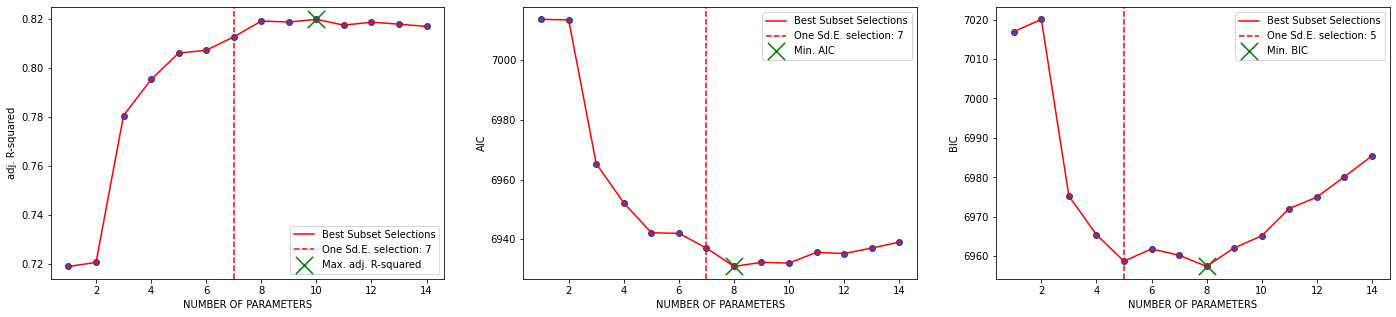

In [16]:
df1,df2,df3=ic(df_bs_min_rss['variables'],df_train_auswahl,df_test,output='salary')
fig=plt.figure(figsize=(24,5))
ax=fig.add_subplot(1,3,1)
ax.scatter(df1.nf,df1.r_squaredadj,alpha=0.7,color='darkblue')
ax.set_xlabel('NUMBER OF PARAMETERS')
ax.set_ylabel('adj. R-squared')
ax.plot(df1.nf,df1.r_squaredadj,color='r',label='Best Subset Selections')
ax.scatter(df2.iloc[2].nf,df2.iloc[2].r_squaredadj,s=300,c='g',marker='x',label='Max. adj. R-squared ')
ax.axvline(df3['One SE adj R sq'],c='r',linestyle='--',label='One Sd.E. selection: {f}'.format(f=df3['One SE adj R sq']))
ax.legend()

ax=fig.add_subplot(1,3,2)
ax.scatter(df1.nf,df1.aic,alpha=0.7,color='darkblue')
ax.set_xlabel('NUMBER OF PARAMETERS')
ax.set_ylabel('AIC')
ax.plot(df1.nf,df1.aic,color='r',label='Best Subset Selections')
ax.scatter(df2.iloc[0].nf,df2.iloc[0].aic,s=300,c='g',marker='x',label='Min. AIC')
ax.axvline(df3['One SE AIC'],c='r',linestyle='--',label='One Sd.E. selection: {f}'.format(f=df3['One SE AIC']))
ax.legend()

ax=fig.add_subplot(1,3,3)
ax.scatter(df1.nf,df1.bic,alpha=0.7,color='darkblue')
ax.set_xlabel('NUMBER OF PARAMETERS')
ax.set_ylabel('BIC')
ax.plot(df1.nf,df1.bic,color='r',label='Best Subset Selections')
ax.scatter(df2.iloc[1].nf,df2.iloc[1].bic,s=300,c='g',marker='x',label='Min. BIC')
ax.axvline(df3['One SE BIC'],c='r',linestyle='--',label='One Sd.E. selection: {f}'.format(f=df3['One SE BIC']))
ax.legend()
plt.savefig('abschnitt.png')
plt.show()

* **We implement a method to frequently plot our results by reusing code**

In [17]:
def ic_plot(df1_bs,df2_bs,df3_bs,df1_fss,df2_fss,df3_fss,df1_be,df2_be,df3_be,one='BS',two='FSS',three='BE',pngname='save as png'):
    fig=plt.figure(figsize=(20,10))
    
    ax=fig.add_subplot(2,2,1)

    if(one!='null'):
        ax.plot(df1_bs.nf,df1_bs.r_squaredadj,color='r',label='{f}'.format(f=one),alpha=0.7)
        ax.scatter(df2_bs.iloc[2].nf,df2_bs.iloc[2].r_squaredadj,s=300,c='r',marker='x')
        ax.axvline(df3_bs['One SE adj R sq'],c='r',linestyle='--',alpha=0.7)
    if (two!='null'):
        ax.plot(df1_fss.nf,df1_fss.r_squaredadj,color='blue',label='{f}'.format(f=two),alpha=0.7)
        ax.scatter(df2_fss.iloc[2].nf,df2_fss.iloc[2].r_squaredadj,s=300,c='blue',marker='x')
        ax.axvline(df3_fss['One SE adj R sq'],c='blue',linestyle='-.',alpha=0.7)
    if (three!='null'):
        ax.plot(df1_be.nf,df1_be.r_squaredadj,color='black',label='{f}'.format(f=three),alpha=0.7)
        ax.scatter(df2_be.iloc[2].nf,df2_be.iloc[2].r_squaredadj,s=300,c='black',marker='x')
        ax.axvline(df3_be['One SE adj R sq'],c='black',linestyle=':',alpha=0.7)
    
    ax.set_xlabel('Number of Variables')
    ax.set_ylabel('adj. R_Squared')
    ax.legend()

    ax=fig.add_subplot(2,2,2)

    if(one!='null'):
        ax.plot(df1_bs.nf,df1_bs.aic,color='r',label='{f}'.format(f=one),alpha=0.7)
        ax.scatter(df2_bs.iloc[0].nf,df2_bs.iloc[0].aic,s=300,c='r',marker='x')
        ax.axvline(df3_bs['One SE AIC'],c='r',linestyle='--',alpha=0.7)
    if(two!='null'):
        ax.plot(df1_fss.nf,df1_fss.aic,color='blue',label='{f}'.format(f=two),alpha=0.7)
        ax.scatter(df2_fss.iloc[0].nf,df2_fss.iloc[0].aic,s=300,c='blue',marker='x')
        ax.axvline(df3_fss['One SE AIC'],c='blue',linestyle='-.',alpha=0.7)
    if(three!='null'):
        ax.plot(df1_be.nf,df1_be.aic,color='black',label='{f}'.format(f=three),alpha=0.7)
        ax.scatter(df2_be.iloc[0].nf,df2_be.iloc[0].aic,s=300,c='black',marker='x')
        ax.axvline(df3_be['One SE AIC'],c='black',linestyle=':',alpha=0.7)
    
    ax.set_xlabel('Number of Variables')
    ax.set_ylabel('AIC')
    ax.legend()

    ax=fig.add_subplot(2,2,3)
    if(one!='null'):
        ax.plot(df1_bs.nf,df1_bs.bic,color='r',label='{f}'.format(f=one),alpha=0.7)
        ax.scatter(df2_bs.iloc[1].nf,df2_bs.iloc[1].bic,s=300,c='r',marker='x')
        ax.axvline(df3_bs['One SE BIC'],c='r',linestyle='--',alpha=0.7)
    if(two!='null'):
        ax.plot(df1_fss.nf,df1_fss.bic,color='blue',label='{f}'.format(f=two),alpha=0.7)
        ax.scatter(df2_fss.iloc[1].nf,df2_fss.iloc[1].bic,s=300,c='blue',marker='x')
        ax.axvline(df3_fss['One SE BIC'],c='blue',linestyle='-.',alpha=0.7)
    if(three!='null'):
        ax.plot(df1_be.nf,df1_be.bic,color='black',label='{f}'.format(f=three),alpha=0.7)
        ax.scatter(df2_be.iloc[1].nf,df2_be.iloc[1].bic,s=300,c='black',marker='x')
        ax.axvline(df3_be['One SE BIC'],c='black',linestyle=':',alpha=0.7)
    
    ax.set_xlabel('Number of Variables')
    ax.set_ylabel('BIC')
    ax.legend()
    ax.legend()
    ax=fig.add_subplot(2,2,4)
    if(one!='null'):
        ax.plot(df1_bs.nf,df1_bs.mse,color='r',label='{f}'.format(f=one),alpha=0.7)
        ax.scatter(df2_bs.iloc[3].nf,df2_bs.iloc[3].mse,s=300,c='r',marker='x')
        ax.axvline(df3_bs['One SE MSE'],c='r',linestyle='--',alpha=0.7)
    if(two!='null'):
        ax.plot(df1_fss.nf,df1_fss.mse,color='blue',label='{f}'.format(f=two),alpha=0.7)
        ax.scatter(df2_fss.iloc[3].nf,df2_fss.iloc[3].mse,s=300,c='blue',marker='x')
        ax.axvline(df3_fss['One SE MSE'],c='blue',linestyle='-.',alpha=0.7)
    if(three!='null'):
        ax.plot(df1_be.nf,df1_be.mse,color='black',label='{f}'.format(f=three),alpha=0.7)
        ax.scatter(df2_be.iloc[3].nf,df2_be.iloc[3].mse,s=300,c='black',marker='x')
        ax.axvline(df3_be['One SE MSE'],c='black',linestyle=':',alpha=0.7)
    
    ax.set_xlabel('Number of Variables')
    ax.set_ylabel('MSE')
    ax.legend()
    plt.savefig('{f}.png'.format(f=pngname))
    plt.show()
    

* **The following plot shows the subset selections for the three information criterion and the directly estimated test mean squared error for all three subset selection methods(Figure 4.5.2)**

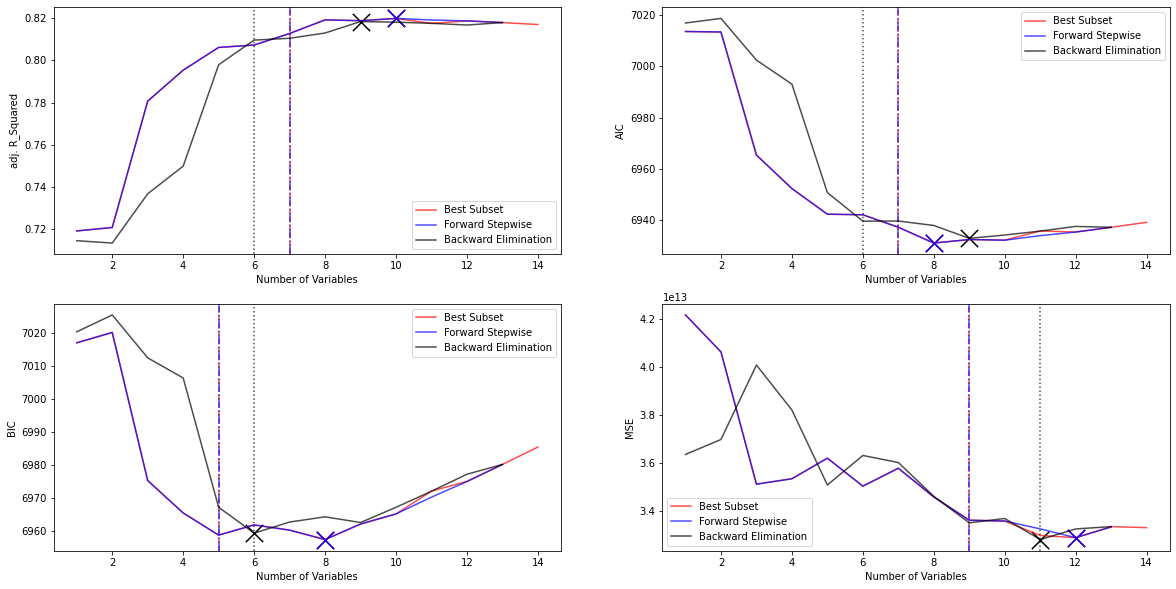

In [18]:
df1_be,df2_be,df3_be=ic(df_be['Variables'],df_train,df_test,output='salary')
df1_fss,df2_fss,df3_fss=ic(df_fss['variables'],df_train,df_test,output='salary')
df1_bs,df2_bs,df3_bs=ic(df_bs_min_rss['variables'],df_train,df_test,output='salary')

ic_plot(df1_bs,df2_bs,df3_bs,df1_fss,df2_fss,df3_fss,df1_be,df2_be,df3_be,
          one='Best Subset',two='Forward Stepwise',three='Backward Elimination',pngname='Figure 4.5.2')

## Comparison with created data
1. Implementation of the data generating method
2. Creating the data
3. Using the data

In [19]:
#Figure 4.1.1
def dataset_declaration(observations,mu=0,related=50,sigma=1,noise=20):
    np.random.seed(42)#define the seed to asure compatibility
    X=np.random.normal(mu, sigma, (observations, related))#related regressormatrix
    X_noise=np.random.normal(mu, sigma, (observations, noise))#unrelated regressormatrix
    if (related==0):
        y=np.random.normal(mu,sigma,(1,observations))#normally distributed y if related regressors aren't provided
    else:
        y=np.zeros((1,observations))
    for i in range(X.shape[1]):
        y+=X[:,i]#sum the related regressors->true coefficients are 1
    X=np.append(X, X_noise,axis=1)#combine unrelated and related regressors  
    y=y.transpose()
    return X,y

In [20]:
#creating data set 1 with 15 observations
X1,y1=dataset_declaration(15,related=0,mu=0,sigma=1,noise=12)
df_self1=pd.DataFrame(X1)
df_self1['pred']=y1
df_train1= df_self1.sample(frac=0.75,random_state=1)
df_test1=df_self1.drop(df_train1.index)

#creating data set 2 with 150 observations
X2,y2=dataset_declaration(150,related=0,mu=0,sigma=1,noise=12)
df_self2=pd.DataFrame(X2)
df_self2['pred']=y2
df_train2= df_self2.sample(frac=0.75,random_state=1)
df_test2=df_self2.drop(df_train2.index)

In [21]:
#computing the best subset selections
df_bs_1=best_subset(df_train1,output='pred')
df_bs_1_rss=df_bs_1[df_bs_1['min_RSS']==df_bs_1['RSS']][['number_of_variables','RSS','R_squared','variables']].reset_index()
df_bs_1_rss=df_bs_1_rss.drop(['index'], axis=1)
df_bs_2=best_subset(df_train2,output='pred')
df_bs_2_rss=df_bs_2[df_bs_2['min_RSS']==df_bs_2['RSS']][['number_of_variables','RSS','R_squared','variables']].reset_index()
df_bs_2_rss=df_bs_2_rss.drop(['index'], axis=1)

In [22]:
#displaying our results -> Figure 4.5.3
from IPython.display import display_html
df1=df_bs_1_rss
df2=df_bs_2_rss
df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('15 observations and 12 unrelated predictors')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('150 observations and 12 unrelated predictors')
space = "\xa0" 
display_html(df1_styler._repr_html_()+space+df2_styler._repr_html_(), raw=True)

,number_of_variables,RSS,R_squared,variables
0,1,3.547795,0.370055,[8]
1,2,1.511968,0.731536,"[8, 9]"
2,3,0.763195,0.864487,"[8, 9, 11]"
3,4,0.377244,0.933017,"[7, 8, 9, 11]"
4,5,0.212006,0.962356,"[1, 7, 8, 9, 11]"
5,6,0.108424,0.980748,"[0, 4, 5, 6, 7, 10]"
6,7,0.029149,0.994824,"[0, 2, 3, 8, 9, 10, 11]"
7,8,0.002092,0.999629,"[0, 3, 4, 5, 6, 7, 10, 11]"
8,9,0.000029,0.999995,"[0, 3, 4, 5, 6, 7, 9, 10, 11]"
9,10,0.000000,1.000000,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 11]"


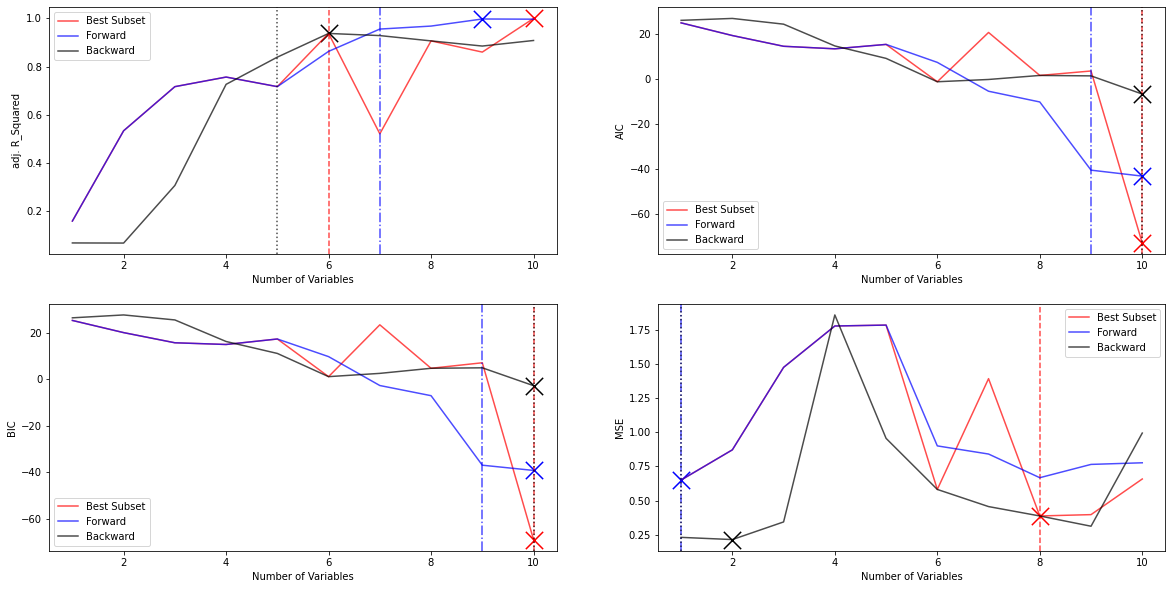

In [23]:
df_be=backwards_elimination(df_train1,output='pred')
df1_be,df2_be,df3_be=ic(df_be['Variables'],df_train1,df_test1,output='pred')
df_fss=forward_stepwise(df_train1,output='pred')
df1_fss,df2_fss,df3_fss=ic(df_fss['variables'],df_train1,df_test1,output='pred')
df1_bs,df2_bs,df3_bs=ic(df_bs_1_rss['variables'],df_train1,df_test1,output='pred')
#plotting Figure 4.5.4
ic_plot(df1_bs,df2_bs,df3_bs,df1_fss,df2_fss,df3_fss,df1_be,df2_be,df3_be,
          one='Best Subset',two='Forward',three='Backward',pngname='own data 15 observations')

## Shrinkage processes
* Ridge regression
* Lasso regression

In [24]:
def best_lambda(lambda_list,df_train,df_test,output='pred',methode='ridge'):
    '''Method to find the minimal lambda value for ridge or lasso'''
    #defining the regressormatrix and target variable for the training and testing set
    Xtr,ytr=df_train[df_train.columns.difference([output])],df_train[output]
    Xtst,ytst=df_test[df_test.columns.difference([output])],df_test[output]
    #creating empty lists, which are later used to save the results
    mse_list,r_squared_list,paramet=[],[],[]
    #iterating over all elements in the given lists (contains all values we want to check for the min lambda) 
    for a in lambda_list:
        #performing the lasso or ridge regression (dependent on the choice at the method call)
        if (methode=='lasso'):
            model=Lasso(alpha=a,normalize=True).fit(Xtr,ytr)
        elif (methode=='ridge'):
            model=Ridge(alpha=a,normalize=True).fit(Xtr,ytr)
        #determining and saving the test error, rsquared and model coefficients    
        r_squared_list.append(model.score(Xtr,ytr))
        mse_list.append(m(ytst,model.predict(Xtst)))
        paramet.append(model.coef_)
    df_p=pd.DataFrame(paramet)
    df_p.columns=Xtr.columns
    #calculating the minimal mse value and its asociated lambda position
    min_mse= min(mse_list)
    lambda_pos= lambda_list[mse_list.index(min_mse)]
    #returning the minimal mse value and its position,as well as the mse and r-squared lists 
    #and the dataframe,which contains all coefficients and their values for each lambda-value-model 
    return min_mse,lambda_pos,mse_list,r_squared_list,df_p

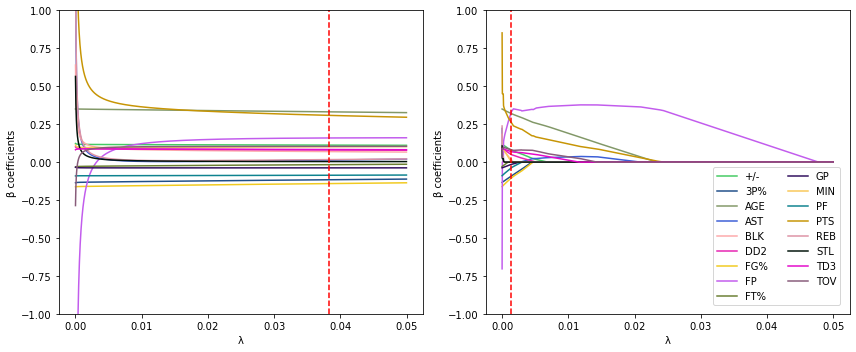

In [25]:
    a=np.arange(0.0,0.05,0.00001)#these are all lambda values we will be setting as alpha into lasso or ridge
    df=(df-df.mean())/df.std()#standardizing the data set
    
    df_train= df.sample(frac=0.75,random_state=1)
    df_test=df.drop(df_train.index)
    min_mse,y_pos,mse_list,r_squared_list,df_p=best_lambda(a,df_train,df_test,output='salary',methode='ridge')
    
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    fig.tight_layout(pad=0.01, w_pad=3, h_pad=1.0)
    
    random.seed(1)
    get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
    color=get_colors(df_p.shape[1])
    
    ax[0].set_prop_cycle(color=color)
    for i in df_p.columns:
        ax[0].plot(a,df_p[i],label=i)
    ax[0].axvline(x=y_pos, color='r',linestyle='--',label= "λ: {f}".format(f=y_pos))
    ax[0].set_ylim(-1,1)
    ax[0].set_ylabel("β coefficients")
    ax[0].set_xlabel("λ")
    ax[1].set_prop_cycle(color=color)
    
    min_mse,y_pos,mse_list,r_squared_list,df_p=best_lambda(a,df_train,df_test,output='salary',methode='lasso')
    for i in df_p.columns:
        ax[1].plot(a,df_p[i],label=i)
    ax[1].set_ylim(-1,1)
    ax[1].axvline(x=y_pos, color='r',linestyle='--')
    ax[1].legend(bbox_to_anchor=(0.8,0.5), loc="upper center",ncol=2)
    ax[1].set_ylabel("β coefficients")
    ax[1].set_xlabel("λ")
    plt.tight_layout()
    plt.savefig('Figure 4 6 2.png')
    plt.show()   

# Creating multiple splits

In [26]:
def mult_split(df,a_r,a_l,count=5,frac=0.7,output='salary'):
    df_train=[df.iloc[df.sample(frac=frac,random_state=i).index]for i in range(1,count+1)]
    df_test=[df.drop(df.sample(frac=frac,random_state=i).index)for i in range(1,count+1)]
    list_index=[df.sample(frac=frac,random_state=i).index for i in range(1,count+1)]
    
    y_train=[df_train[i][output] for i in range(count)]
    X_train=[df_train[i][df.columns.difference([output])] for i in range(count)]
    y_test=[df_test[i][output] for i in range(count)]
    X_test=[df_test[i][df.columns.difference([output])] for i in range(count)]
    
    ridge=[best_lambda(a_r,df_train[i],df_test[i],output=output)for i in range(count)]
    lasso=[best_lambda(a_l,df_train[i],df_test[i],output=output, methode='lasso')for i in range(count)]
    
    return ridge,lasso,y_train,X_train,y_test,X_test

* **First for the standardized NBA data Set**

In [27]:
df=(df-df.mean())/df.std()
df = pd.read_csv("bearbeitet.csv", sep=",")
df=df[['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']]#new data
df=(df-df.mean())/df.std()

count=15
a_r=np.arange(0,1.,0.01)
a_l=np.arange(0,0.02,0.0001)
ridge,lasso,y_train,X_train,y_test,X_test=mult_split(df,a_r,a_l,count=count)

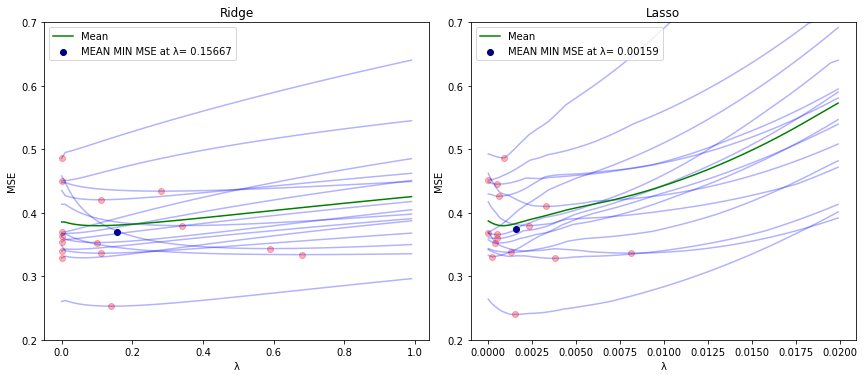

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
from operator import add
fig.tight_layout()

ridgel=[b[2]for b in ridge]
ridge_mse_mean=np.sum([b[2]for b in ridge],0)/count


ridge_y_pos_mean=np.sum([b[1] for b in ridge])/count
ridge_min_mse_mean=np.sum([b[0] for b in ridge])/count

for b in ridge:
    min_mse,y_pos,mse_list,r_squared_list,df_p=b   
    ax[0].plot(a_r,mse_list,color='b',alpha=0.3)
    ax[0].scatter(y_pos,min_mse,color='r',alpha=0.3)

ax[0].plot(a_r,ridge_mse_mean,color='g',label='Mean',alpha=1.0)
ax[0].scatter(ridge_y_pos_mean,ridge_min_mse_mean,color='Navy',label='MEAN MIN MSE at λ= '+str(round(ridge_y_pos_mean,5)),alpha=1.0)
ax[0].set_ylim(0.2,0.7)   
ax[0].set_xlabel('λ')
ax[0].set_ylabel('MSE')
ax[0].legend()
ax[0].set_title('Ridge')
 
lasso_mse_mean=np.sum([b[2]for b in lasso],0)/count
lasso_y_pos_mean=np.sum([b[1] for b in lasso])/count
lasso_min_mse_mean=np.sum([b[0] for b in lasso])/count

for b in lasso:
    min_mse,y_pos,mse_list,r_squared_list,df_p=b   
    ax[1].plot(a_l,mse_list,color='b',alpha=0.3)
    ax[1].scatter(y_pos,min_mse,color='r',alpha=0.3)

ax[1].plot(a_l,lasso_mse_mean,color='g',label='Mean',alpha=1.0)
ax[1].scatter(lasso_y_pos_mean,lasso_min_mse_mean,color='Navy',label='MEAN MIN MSE at λ= '+str(round(lasso_y_pos_mean,5)),alpha=1.0)
ax[1].set_ylim(0.2,0.7)  
ax[1].set_xlabel('λ')
ax[1].set_ylabel('MSE')
ax[1].legend(loc='upper left')
ax[1].set_title('Lasso')
plt.savefig('ridge_lasso_multisplit.png')    
plt.show()

* **Then for a created data set -> Figure 4.6.3**

In [29]:
X,y=dataset_declaration(15,related=5,mu=0,sigma=1,noise=12)
df_self=pd.DataFrame(X)
df_self['pred']=y
df_train= df_self.sample(frac=0.75,random_state=1)
df_test=df_self.drop(df_train.index)

In [30]:
count=15
a_r=np.arange(0,2,0.01)
a_l=np.arange(0,0.001,0.00001)
ridge,lasso,y_train,X_train,y_test,X_test=mult_split(df_self,a_r,a_l,count=count,output='pred')

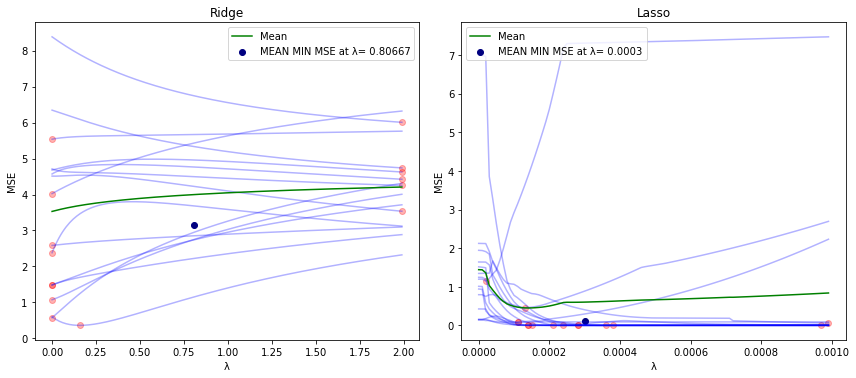

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
from operator import add
fig.tight_layout()

ridgel=[b[2]for b in ridge]
ridge_mse_mean=np.sum([b[2]for b in ridge],0)/count


ridge_y_pos_mean=np.sum([b[1] for b in ridge])/count
ridge_min_mse_mean=np.sum([b[0] for b in ridge])/count

for b in ridge:
    min_mse,y_pos,mse_list,r_squared_list,df_p=b   
    ax[0].plot(a_r,mse_list,color='b',alpha=0.3)
    ax[0].scatter(y_pos,min_mse,color='r',alpha=0.3)

ax[0].plot(a_r,ridge_mse_mean,color='g',label='Mean',alpha=1.0)
ax[0].scatter(ridge_y_pos_mean,ridge_min_mse_mean,color='Navy',label='MEAN MIN MSE at λ= '+str(round(ridge_y_pos_mean,5)),alpha=1.0)
#ax[0].set_ylim(0.2,0.7)   
ax[0].set_xlabel('λ')
ax[0].set_ylabel('MSE')
ax[0].legend()
ax[0].set_title('Ridge')
 
lasso_mse_mean=np.sum([b[2]for b in lasso],0)/count
lasso_y_pos_mean=np.sum([b[1] for b in lasso])/count
lasso_min_mse_mean=np.sum([b[0] for b in lasso])/count

for b in lasso:
    min_mse,y_pos,mse_list,r_squared_list,df_p=b   
    ax[1].plot(a_l,mse_list,color='b',alpha=0.3)
    ax[1].scatter(y_pos,min_mse,color='r',alpha=0.3)

ax[1].plot(a_l,lasso_mse_mean,color='g',label='Mean',alpha=1.0)
ax[1].scatter(lasso_y_pos_mean,lasso_min_mse_mean,color='Navy',label='MEAN MIN MSE at λ= '+str(round(lasso_y_pos_mean,5)),alpha=1.0)
#ax[1].set_ylim(0.2,0.7)  
ax[1].set_xlabel('λ')
ax[1].set_ylabel('MSE')
ax[1].legend(loc='upper left')
ax[1].set_title('Lasso')
plt.savefig('Figure 4 6 3.png')    
plt.show()

# Comparing the results of each method 
* **selection: its main purpose is to determines the variable selection property of the lasso regression**
* **min_mse: calculates the test mean squarred error estimate for a given subset dataframe**
* **mult_split_be: computes the backwards elimination and forward stepwise selection for multiple splits**
* **choice: counts the number of included variables in the given subset dataframe**
* **meanf: determines the minimal test mse mean and the mean number of non-zero variables over different splits**

In [32]:
def selection(reg,y_train,X_train,count=5,threshold=0.8,method='Lasso'):
    #saving the minimal lambda values and all Dataframes for later use
    min_y=[l[1]for l in reg]
    df_full=[l[4]for l in reg]
    if(method=='Ridge'):
        #when we want to receive all ridge models with the minimal test error estimate
        df_best_lambda=pd.DataFrame([Ridge(alpha=min_y[j]).fit(X_train[j],y_train[j]).coef_ for j in range(count)])
        df_best_lambda.columns=df_full[1].columns         
        
        
    elif(method=='Lasso'):
        df_best_lambda=pd.DataFrame([Lasso(alpha=min_y[j]).fit(X_train[j],y_train[j]).coef_ for j in range(count)])#Liste mit allen optimalen DF Koeffizienten
        #arange columns
        df_best_lambda.columns=df_full[1].columns
    #filter the columns and making a new dataframe to show what regressors are included in each model
    liste=pd.DataFrame()
    liste3=[]
    #iterating over each row
    for index, row in df_best_lambda[:count].iterrows():
        #we iterate over each row, so over each optimal model for each different split
        liste2=[]#creating a temporary list to overwrite the results for each model
        for i in range(len(df_best_lambda[1:].columns)):
            #selecting the column name, if the value isnt 0 and '---' if it is
            if row[i] !=0:
                #if the value of the variable is not zero overwrite the value with the variable name
                liste2.append(str(row.index[i]))
            else :
                #if the value of the variable is zero overwrite the value with the String: '---'
                liste2.append('---')
                    
        liste3.append(liste2)
    #liste.append(liste3)
    liste=pd.DataFrame(liste3)
        
    #creating a count column to count the nonzero variables of each split
    df_best_lambda['Count'] = df_best_lambda[df_best_lambda.columns].ne(0).sum(axis=1)
        
    #making an index shift at the columns, so the Count column is in front
    cols=df_best_lambda.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_best_lambda=df_best_lambda[cols]
        

    #counting the nonzero variables over all splits 
    temp=[]
    for i in range(liste.shape[1]):
        #iterating over all variables, saving the column name and counting the values
        temp.append((cols[i+1],liste[i].value_counts()[str(cols[i+1])]))
    df_count=pd.DataFrame(temp)
    df_count=df_count.transpose()
    df_count.columns = df_count.iloc[0]
    df_count=df_count.iloc[1:,:]
    df_count.index=['Count {f}'.format(f=method)]
        #print(display(var1.sort_values(by=1,axis=1,ascending=False)))
        #sorting the df_count dataframe, so the frequently selected variables are in front
    df_return=df_count.sort_values(by='Count {f}'.format(f=method),axis=1,ascending=False)
        #print('Regressors that are included in {t}% of the models:'.format(t=threshold*100))
        #print(display(var1[var1>threshold*count].dropna(axis=1).sort_values(by=1,axis=1, ascending=False) ))
    return df_return,df_best_lambda

* **exemplary output of the selection method**

In [33]:
df = pd.read_csv("bearbeitet.csv", sep=",")
df=df[['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']]#new data
df=(df-df.mean())/df.std()

count=15
a_r=np.arange(0,2.,0.01)
a_l=np.arange(0,0.02,0.0001)
ridge,lasso,y_train,X_train,y_test,X_test=mult_split(df,a_r,a_l,count=count)

In [34]:
k,d=selection(lasso,y_train,X_train,count=count,threshold=0.9,method='Lasso')
display(k)
k,d=selection(ridge,y_train,X_train,count=count,threshold=0.9,method='Ridge')
display(d)

,+/-,3P%,TD3,REB,PTS,PF,MIN,GP,FT%,FG%,BLK,AGE,TOV,DD2,STL,AST,FP
Count Lasso,15,15,15,15,15,15,15,15,15,15,15,15,15,14,14,10,9


,Count,+/-,3P%,AGE,AST,BLK,DD2,FG%,FP,FT%,GP,MIN,PF,PTS,REB,STL,TD3,TOV
0,17,0.111735,-0.129521,0.363136,0.242529,0.183107,0.082580,-0.176255,-0.715386,-0.024123,-0.035202,0.086365,-0.068421,0.887085,0.268452,0.119114,0.117256,-0.027987
1,17,0.081546,-0.141124,0.386106,-0.028300,0.078535,-0.104453,-0.202448,0.287158,-0.006552,-0.039926,-0.084231,-0.030625,0.579751,0.093341,-0.044662,0.079489,0.019102
2,17,0.070791,-0.045016,0.304042,0.569770,0.384314,0.068870,-0.187536,-2.013206,-0.031574,-0.012675,-0.028168,-0.127082,1.677588,0.663770,0.294209,0.116950,-0.055301
3,17,0.088131,-0.097095,0.333454,0.365315,0.229429,-0.048474,-0.149423,-0.981328,-0.009759,-0.052424,-0.011262,-0.084500,1.072366,0.470870,0.119405,0.104088,-0.017956
4,17,0.122990,-0.089090,0.306231,0.584766,0.382815,0.009753,-0.180334,-1.816177,-0.016230,-0.010513,-0.040333,-0.133995,1.566680,0.690075,0.266231,0.093264,-0.123211
5,17,0.037798,-0.106480,0.360174,0.679535,0.421448,0.034656,-0.159532,-2.372540,-0.000470,-0.000603,0.014749,-0.084929,1.861252,0.781559,0.334596,-0.030958,-0.141133
6,17,0.053481,-0.110810,0.345391,0.263815,0.263442,0.064058,-0.178299,-0.569250,-0.013654,-0.008478,-0.009585,-0.112815,0.894023,0.212955,0.096257,0.062033,-0.037656
7,17,0.064864,-0.085869,0.333803,0.091658,0.134648,-0.056126,-0.154134,0.174365,0.017906,-0.069183,-0.096712,-0.116062,0.426548,0.184051,0.020384,0.050939,0.181053
8,17,0.056499,-0.088043,0.364391,-0.033309,0.129503,-0.071910,-0.166120,0.046345,-0.004473,-0.022114,0.043170,-0.163509,0.446908,0.227368,0.014110,0.157623,0.125689
9,17,0.037585,-0.078732,0.290078,0.214063,0.133551,0.055026,-0.078179,-0.005731,0.007079,-0.056462,-0.071197,-0.137710,0.591579,0.074274,0.031503,-0.007996,0.065574


In [35]:
def min_mse(df_subset,df1,df_test,output='pred'):
    Xtr,ytr=df1[df1.columns.difference([output])],df1[output]
    Xtst,ytst=df_test[df_test.columns.difference([output])],df_test[output]#the test split from our data
    variables,mse_list=[],[]
    for i in df_subset:
        x,y=Xtr[i],ytr
        model = sm.OLS(y, x).fit()#fitting the model
        pred_y=model.predict(Xtst[i])#predicting the target variable
        mse= m(ytst,pred_y)#calculating the test mse of our predictions and the actual values 
        mse_list.append(mse)
        variables.append(i)
    df=pd.concat([pd.DataFrame({'variables':variables}),pd.DataFrame({'mse':mse_list})], axis=1, join='inner')
    df['nf']=[len(i) for i in df['variables']]
    df.dropna()
    df_selection=df[df['mse']==min(df['mse'])]
    df_selection_one_se=dict()
    df_selection_one_se['One SE MSE']=min(df[df['mse']-stats.sem(df.mse)<=min(df['mse'])]['nf'])
    return df,df_selection,df_selection_one_se

In [36]:
def mult_split_be(df,count=5,frac=0.7,output='salary'):
    df_train=[df.iloc[df.sample(frac=frac,random_state=i).index]for i in range(1,count+1)]
    df_test=[df.drop(df.sample(frac=frac,random_state=i).index)for i in range(1,count+1)]
    list_index=[df.sample(frac=frac,random_state=i).index for i in range(1,count+1)]
    
    y_train=[df_train[i][output] for i in range(count)]
    X_train=[df_train[i][df.columns.difference([output])] for i in range(count)]
    y_test=[df_test[i][output] for i in range(count)]
    X_test=[df_test[i][df.columns.difference([output])] for i in range(count)]
    
    #calculating the forward and backward stepwise methods for each split
    backwards=[backwards_elimination(df_train[i],output=output)for i in range(count)]
    forwards=[forward_stepwise(df_train[i],output=output)for i in range(count)]
    
    #computing the minimum for each split
    be_mse=[min_mse(backwards[i]['Variables'],df_train[i],df_test[i],output=output)[1] for i in range(count)]
    fe_mse=[min_mse(forwards[i]['variables'],df_train[i],df_test[i],output=output)[1] for i in range(count)]
    #creating a dataframe object
    be_mse1=pd.concat([pd.DataFrame(be_mse[i])for i in range(count)],axis=0,join='inner')
    fe_mse1=pd.concat([pd.DataFrame(fe_mse[i])for i in range(count)],axis=0,join='inner')
    be_mse1=be_mse1.reset_index()
    fe_mse1=fe_mse1.reset_index()
    
    return backwards,forwards,df_train,df_test,be_mse1,fe_mse1

In [37]:
def choice(be_mse,cols,method,count=5,output='salary'):
    #calculating the count of variable selections of the subset methods similar to 'selection'
    h,k=[],[]
    for i in range(count):
        for j in be_mse ['variables'][i]:
            h.append(j)
    for i in cols:
            count_a = h.count(i)
            k.append([i,count_a])
    k=pd.DataFrame(k)
    k.columns=['Variable','Count {f}'.format(f=method)]
    k=k.transpose()
    k.columns = k.iloc[0]
    k=k.iloc[1:]
    k=k.drop([output], axis = 1)
    return k

In [38]:
def meanf(be_mse,fe_mse,lasso,ridge,df_lasso,df_ridge):
    #calculating the mean of the estimated test error and included features for the 4 methods
    be_mean_mse=round(np.mean(be_mse['mse']),5)
    fe_mean_mse=round(np.mean(fe_mse['mse']),5)
    ridge_mean_mse=np.mean([i[0]for i in ridge])
    lasso_mean_mse=np.mean([i[0]for i in lasso])
    msem=[be_mean_mse,fe_mean_mse,ridge_mean_mse,lasso_mean_mse]
    #feature mean
    be_mean_nf=round(np.mean(be_mse['nf']),5)
    fe_mean_nf=round(np.mean(fe_mse['nf']),5)
    lasso_mean_nf=np.mean(df_lasso.transpose()['Count Lasso'])
    ridge_mean_nf=np.mean(df_ridge.transpose()['Count Ridge'])
    nfm=[be_mean_nf,fe_mean_nf,ridge_mean_nf,lasso_mean_nf]

    mean=pd.concat([pd.DataFrame({'min_mse_mean':msem}),pd.DataFrame({'nf_mean':nfm})],axis=1,join='inner')
    mean.index=['Backwards','Forwards','Ridge','Lasso']
    return mean

# Combining the methods on the standardized NBA data set

In [39]:
df = pd.read_csv("bearbeitet.csv", sep=",")
df=df[['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']]
df=(df-df.mean())/df.std()
op='salary'

count=15
a_r=np.arange(0,2.,0.01)
a_l=np.arange(0,2.,0.01)
#calculating the methods over multiple splits
ridge,lasso,y_train,X_train,y_test,X_test=mult_split(df,a_r,a_l,count=count)
backwards,forwards,df_train,df_test,be_mse,fss_mse=mult_split_be(df,count=count,frac=0.7,output=op)

In [40]:
cols=['+/-', '3P%', 'AGE', 'AST', 'BLK', 'DD2' , 'FG%',
        'FP', 'FT%', 'GP', 'MIN' , 'PF',
       'PTS', 'REB', 'STL', 'TD3', 'TOV',  'salary']
df_be=choice(be_mse,cols,'backwards',count=count,output=op)
df_fss=choice(fss_mse,cols,'forwards',count=count,output=op)


df_lasso=selection(lasso,y_train,X_train,count=count,threshold=0.9,method='Lasso')[0]

df_ridge=selection(ridge,y_train,X_train,count=count,threshold=0.9,method='Ridge')[0]

df_sub=pd.concat([df_be,df_fss,df_ridge,df_lasso],join="inner")
df_sub=df_sub.sort_values(by='Count backwards',axis=1,ascending=False)
display(df_sub)
#display the variables that are included in 50% of the model
display(df_sub[df_sub>0.5*count].dropna(axis=1))

df_mean=meanf(be_mse,fss_mse,lasso,ridge,df_lasso,df_ridge)
df_sub.index=df_mean.index
display(df_mean)
df_sub['mean min MSE']=df_mean['min_mse_mean']
df_sub['mean number variables']=df_mean['nf_mean']

,PTS,AGE,BLK,FG%,3P%,REB,+/-,AST,TD3,PF,FP,STL,TOV,GP,DD2,MIN,FT%
Count backwards,15,15,10,10,10,10,9,9,9,9,6,6,3,2,2,1,1
Count forwards,9,15,8,11,9,5,8,4,8,10,14,4,6,4,1,4,1
Count Ridge,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
Count Lasso,15,15,15,15,15,14,15,11,15,15,15,13,14,15,12,14,13


,PTS,AGE,BLK,FG%,3P%,+/-,TD3,PF
Count backwards,15,15,10,10,10,9,9,9
Count forwards,9,15,8,11,9,8,8,10
Count Ridge,15,15,15,15,15,15,15,15
Count Lasso,15,15,15,15,15,15,15,15


,min_mse_mean,nf_mean
Backwards,0.369060,8.466670
Forwards,0.372180,8.066670
Ridge,0.369841,15.000000
Lasso,0.381770,14.176471


* **Figure 4.7.1**

In [41]:
display(df_sub)

,PTS,AGE,BLK,FG%,3P%,REB,+/-,AST,TD3,PF,FP,STL,TOV,GP,DD2,MIN,FT%,mean min MSE,mean number variables
Backwards,15,15,10,10,10,10,9,9,9,9,6,6,3,2,2,1,1,0.369060,8.466670
Forwards,9,15,8,11,9,5,8,4,8,10,14,4,6,4,1,4,1,0.372180,8.066670
Ridge,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.369841,15.000000
Lasso,15,15,15,15,15,14,15,11,15,15,15,13,14,15,12,14,13,0.381770,14.176471
